In [1]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation.metrics import *
from neuralhydrology.nh_run import start_run, eval_run, finetune


import pandas as pd

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
import warnings
warnings.filterwarnings('ignore')

2024-02-13 23:14:57,744: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/exploration_run_1302_231457/output.log initialized.
2024-02-13 23:14:57,745: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/exploration_run_1302_231457
2024-02-13 23:14:57,746: ### Run configurations for exploration_run
2024-02-13 23:14:57,747: experiment_name: exploration_run
2024-02-13 23:14:57,748: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-13 23:14:57,748: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-13 23:14:57,749: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-13 23:14:57,749: train_start_date: 1982-10-01 00:00:00
2024-02-13 23:14:57,750: train_end_date: 1990-09-30 00:00:00
2024-02-13 23:14:57,750: validation_start_date: 1901-10-01 00:00:00
2024-02-13 23:14:57,750: validation_end_date: 2000-09-30 00:00:00
2024-02-13 23:14:57,751: test_start_date:

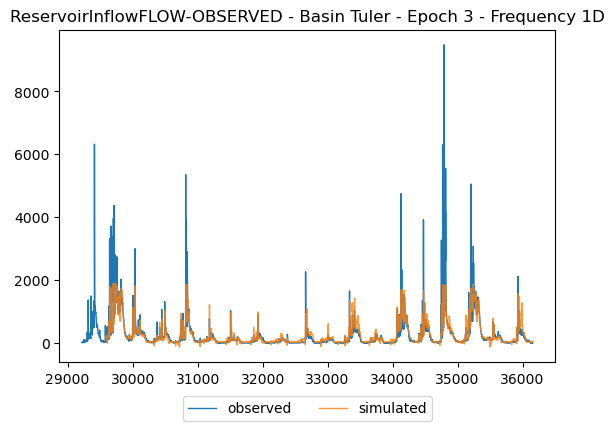

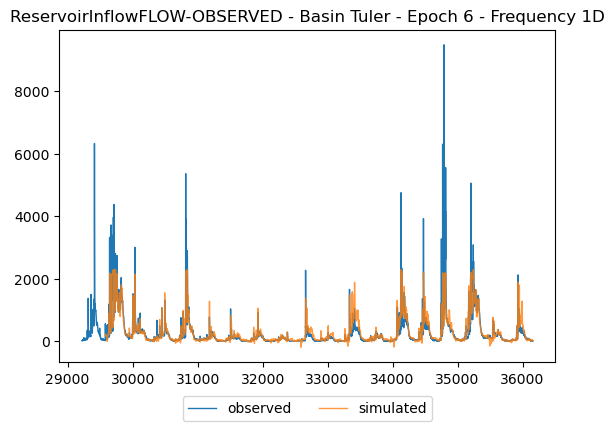

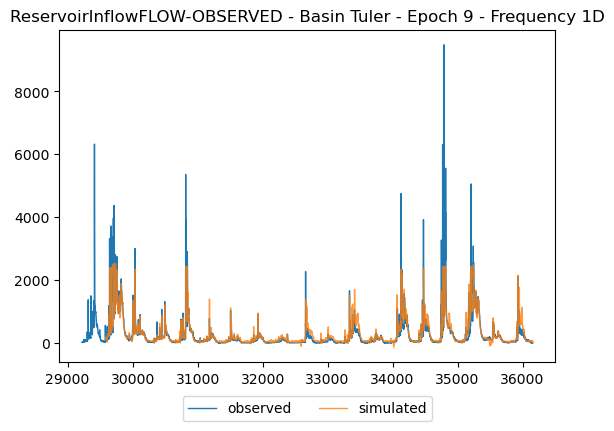

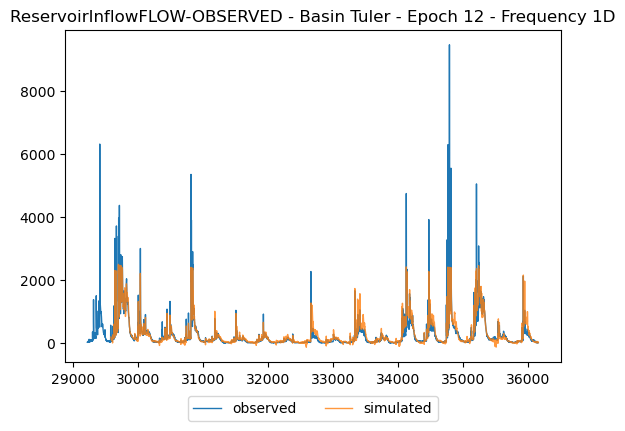

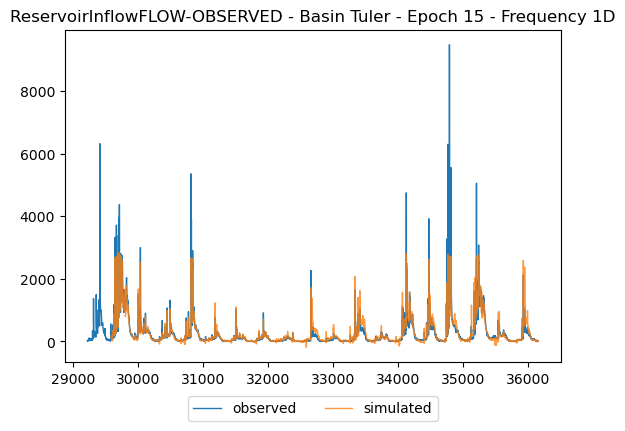

In [4]:
start_run(config_file=Path("../initial_exploration/1_basin.yml"), gpu=-1)

Evaluate on test set

In [5]:
# change directory to directory specified by above cell

run_dir = Path("runs/exploration_run_1302_231457")
eval_run(run_dir=run_dir, period="test")



2024-02-13 23:19:59,029: Using the model weights from runs/exploration_run_1302_231457/model_epoch015.pt
# Evaluation: 100%|██████████| 1/1 [00:00<00:00,  1.52it/s]
2024-02-13 23:19:59,699: Stored metrics at runs/exploration_run_1302_231457/test/model_epoch015/test_metrics.csv
2024-02-13 23:19:59,700: Stored results at runs/exploration_run_1302_231457/test/model_epoch015/test_results.p


Load and inspect model predictions

In [6]:
with open(run_dir / "test" / "model_epoch015" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['Tuler'])

In [7]:
results['Tuler']['1D']['xr']

<xarray.Dataset>
Dimensions:                           (date: 1461, time_step: 1)
Coordinates:
  * date                              (date) datetime64[ns] 2001-10-01 ... 20...
  * time_step                         (time_step) int64 0
Data variables:
    ReservoirInflowFLOW-OBSERVED_obs  (date, time_step) float32 3.2 1.1 ... 20.1
    ReservoirInflowFLOW-OBSERVED_sim  (date, time_step) float32 12.79 ... 10.53

In [8]:
#get output from physical model to plot with LSTM output

df = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/HMS_inflow_results_data.csv')

physical_data = df[['Date', 'ReservoirInflowFLOW']]
physical_data["Date"] = pd.to_datetime(physical_data["Date"])

start_date = '2001-10-01'
end_date = '2005-09-30'

# Filter the DataFrame to keep only the dates within the specified range
physical_data = physical_data[(physical_data['Date'] >= start_date) & (physical_data['Date'] <= end_date)]

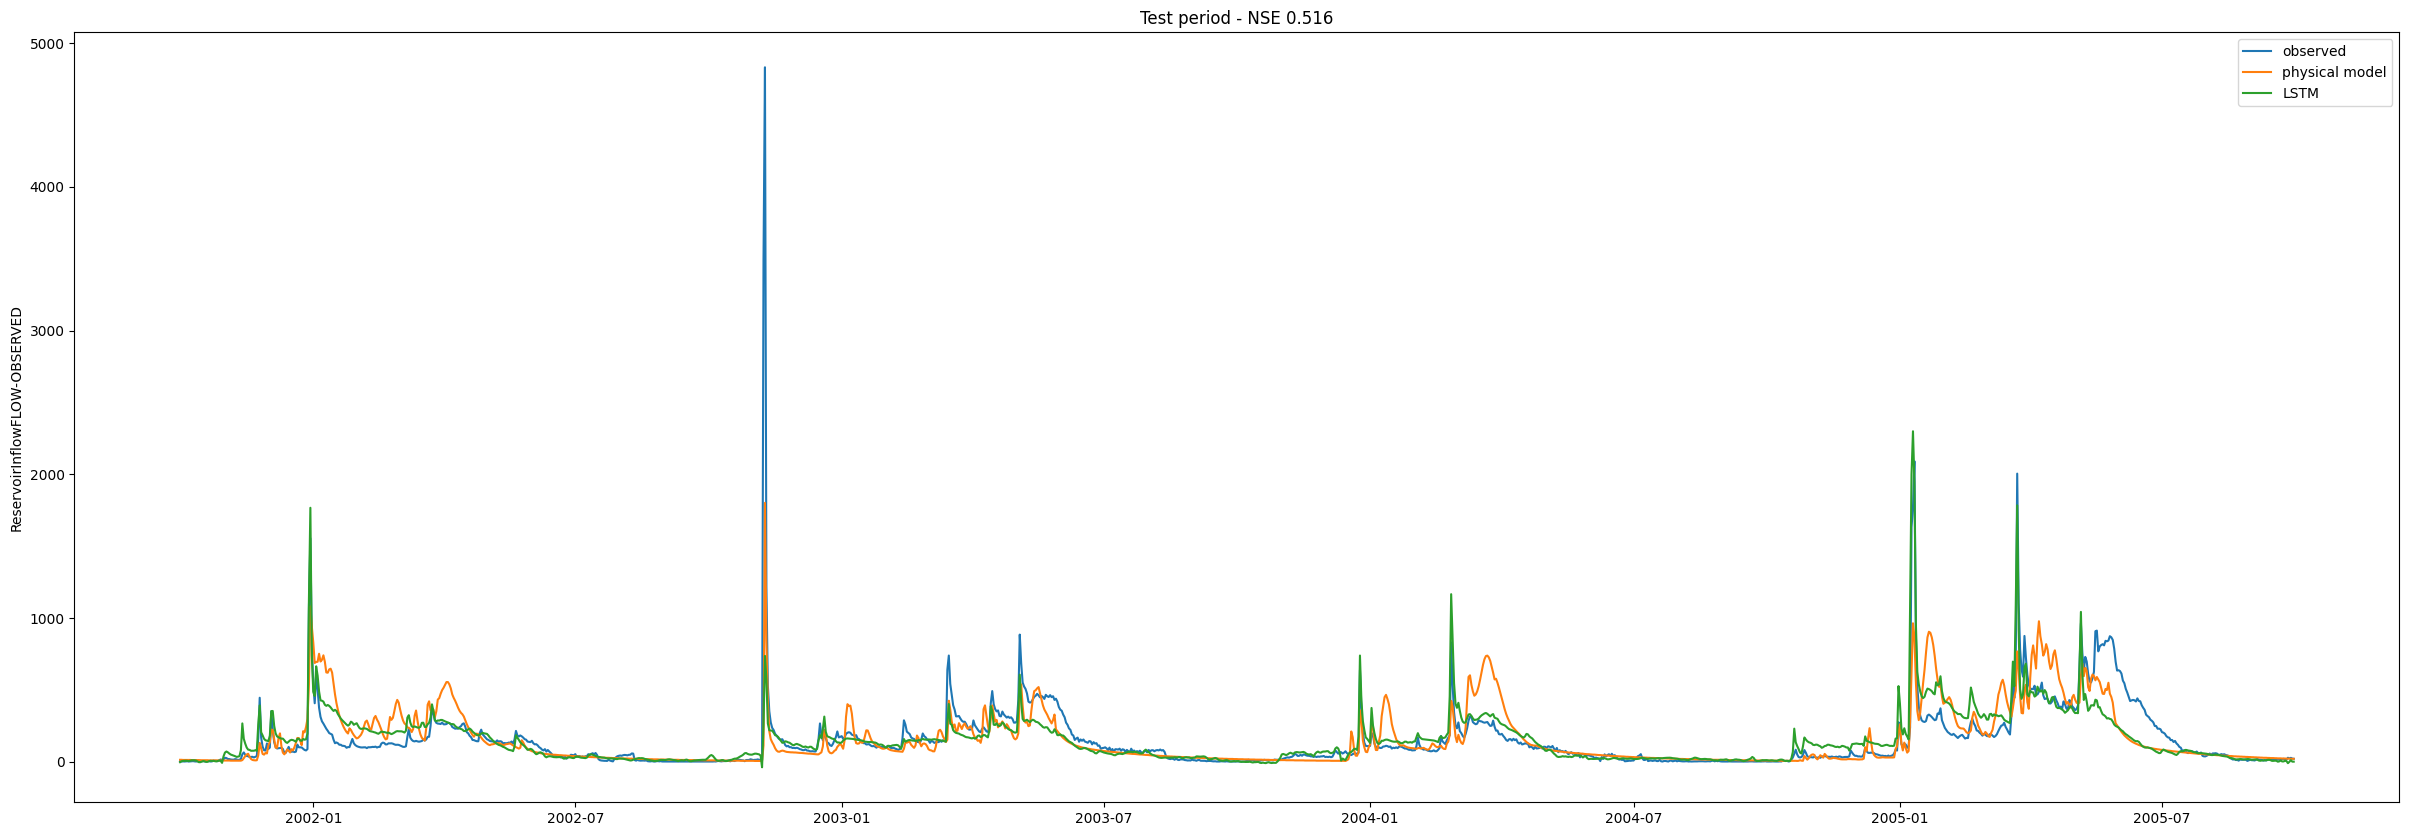

In [13]:
# extract observations and LSTM simulations
qobs = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(30,10))
ax.plot(physical_data["Date"], qobs, label = "observed")
ax.plot(physical_data["Date"], physical_data['ReservoirInflowFLOW'], label= "physical model")
ax.plot(physical_data["Date"], qsim, label = "LSTM")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.set_title(f"Test period - NSE {results['Tuler']['1D']['NSE']:.3f}")
ax.legend()
plt.show()

